## LSTM On the Merged Data - Final Attempt at finding patterns 

In [42]:
# Imports 
import pandas as pd  
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("Final_Merged_Data.csv", index_col=0)

In [13]:
features = df[["Average Sentiment", "Normalised Average Price"]]

In [14]:
# Create Sequences 
def create_sequences(data, sequence_length):
    X, y = [], [] 
    for i in range(len(data) - sequence_length): 
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 1]) # Normalised Average 
    return np.array(X), np.array(y) 

sequence_length = 10 

X,y = create_sequences(features.values, sequence_length) 

In [15]:
# Create Sequences 
def create_sequences(data, sequence_length):
    X, y = [], [] 
    for i in range(len(data) - sequence_length): 
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 1]) # Normalised Average 
    return np.array(X), np.array(y) 

sequence_length = 10 

X,y = create_sequences(features.values, sequence_length) 

# Split Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train = X_train.astype('float32')  # Convert to float32

# Build LSTM Model 
model = Sequential() 
model.add(LSTM(50, input_shape=(sequence_length, 2), return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Hyperparameter Tuning
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Checkpoint 
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

# Early Stopping 
early_stopping = EarlyStopping(patience=10, restore_best_weights=True) 

In [28]:
# Train The Model 
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/50
9/9 [==============================] - 0s 17ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 2/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 3/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 4/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0036 - val_loss: 0.0052
Epoch 5/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 6/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.0052
Epoch 7/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 8/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 9/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 10/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 11/50
9/9 [============

In [29]:
# Evaluate the Model
predictions = model.predict(X_test)
mse = np.mean((predictions - y_test)**2)
print(f"Mean Squared Error: {mse}")

2/2 [==============================] - 0s 5ms/step
Mean Squared Error: 0.0937933586306661


1/1 [==============================] - 0s 17ms/step


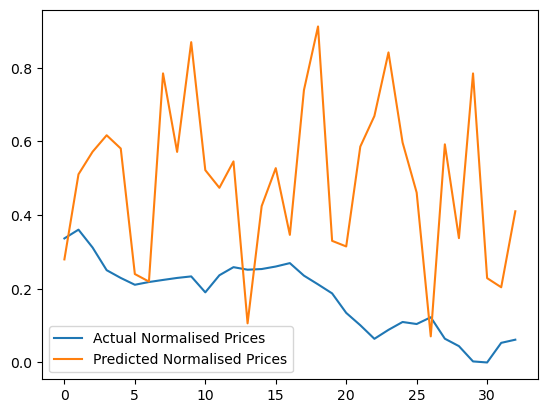

In [30]:
# Load the best model (optional) 
model.load_weights("best_model.h5")

# Make Predictions
last_sequence = X[-1]
prediction = model.predict(np.array([last_sequence]))[0][0]

# Visualize Results
actual_prices = df['Normalised Average Price'].values
plt.plot(actual_prices[-len(predictions):], label='Actual Normalised Prices')
plt.plot(predictions, label='Predicted Normalised Prices')
plt.legend()
plt.show()

# K-fold Cross Validation 

In [31]:
from sklearn.model_selection import TimeSeriesSplit

1/1 [==============================] - 0s 334ms/step
Average Mean Squared Error: 0.03119220004537359


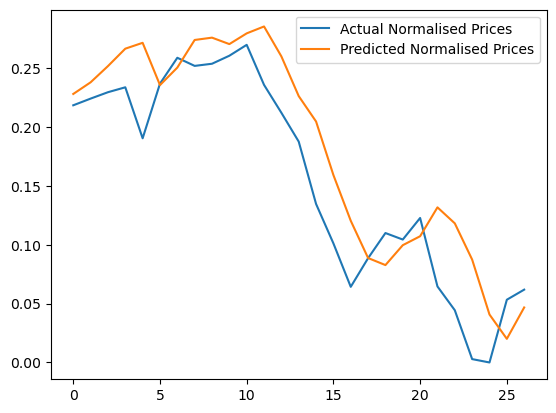

In [44]:
# Split the data into k folds using TimeSeriesSplit 
k = 5 
tcsv = TimeSeriesSplit(n_splits=k) 

# Init an array to store evaluation results 
mse_scores = [] 

# Perform k-fold cross validation 
for train_index, test_index in tcsv.split(X,y): 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index] 
    
    # create and compile the model (as shown in previous code)
    model = Sequential()
    model.add(LSTM(50, input_shape=(sequence_length, 2), return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #Early Stopping 
    # early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    
    # Train the model
    history = model.fit(X_train, y_train, batch_size=16, epochs=200, verbose=0)
    
    # Evaluate the model on the test set
    predictions = model.predict(X_test)
    mse = np.mean((predictions - y_test)**2)
    mse_scores.append(mse)
    

# Average MSE over all K folds 
average_mse = np.mean(mse_scores) 
print(f"Average Mean Squared Error: {average_mse}")

# Visualise Results 
actual_prices = df["Normalised Average Price"].values 
plt.plot(actual_prices[-len(predictions):], label="Actual Normalised Prices") 
plt.plot(predictions, label="Predicted Normalised Prices") 
plt.legend() 
plt.savefig("actualvspredictedNormalised.png")
plt.show()